# tutorial for *ATOL: Automatic Topologically-Oriented Learning*

__Author:__ Martin Royer

## Outline:
In this notebook:
- select a graph dataset that exists in the /perslay/ submodule
- generate the associated persistence diagrams
- show an example of centers and ATOL-features
- run a ten-fold classification experiment solely based on the resulting ATOL graph features

### Select problem and budget

In [3]:
import os
import numpy as np
from itertools import product
import sys
sys.path.append('..')
graph_problem = "NCI109"
graph_folder = "../../perslay/tutorial/data/" + graph_problem + "/" # this should point to a perslay repository

### Compute HKS-extended persistence diagrams for this problem

In [4]:
from atol.utils import compute_tda_for_graphs
print("- [%s] TDA computation" % graph_problem)
filtrations=['0.1-hks', '10.0-hks']
compute_tda_for_graphs(graph_folder=graph_folder, filtrations=filtrations)

- [NCI109] TDA computation
Pad size for eigenvalues in this dataset is: 111


### Compute centers and features, plot

In [5]:
from atol.utils import graph_dtypes, csv_toarray, atol_feats_graphs
from atol.atol import Atol
from sklearn.cluster import MiniBatchKMeans

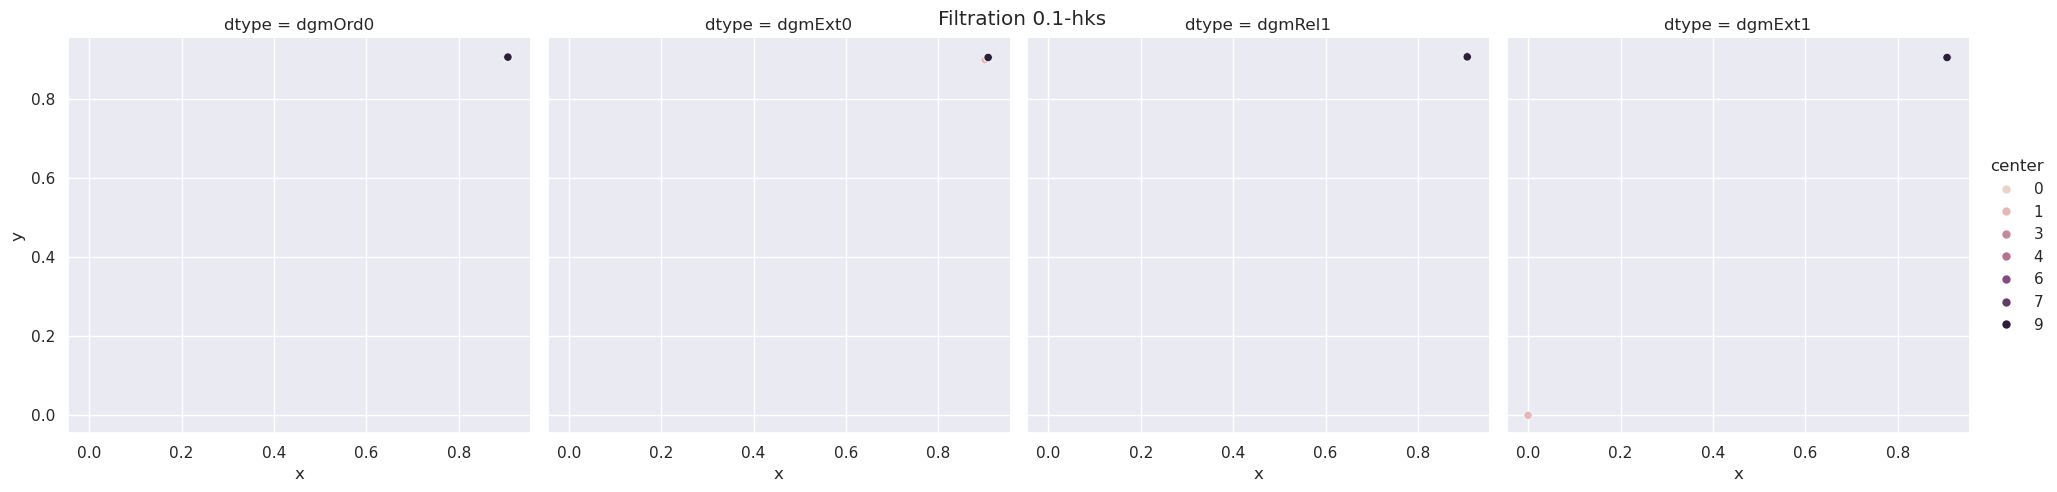

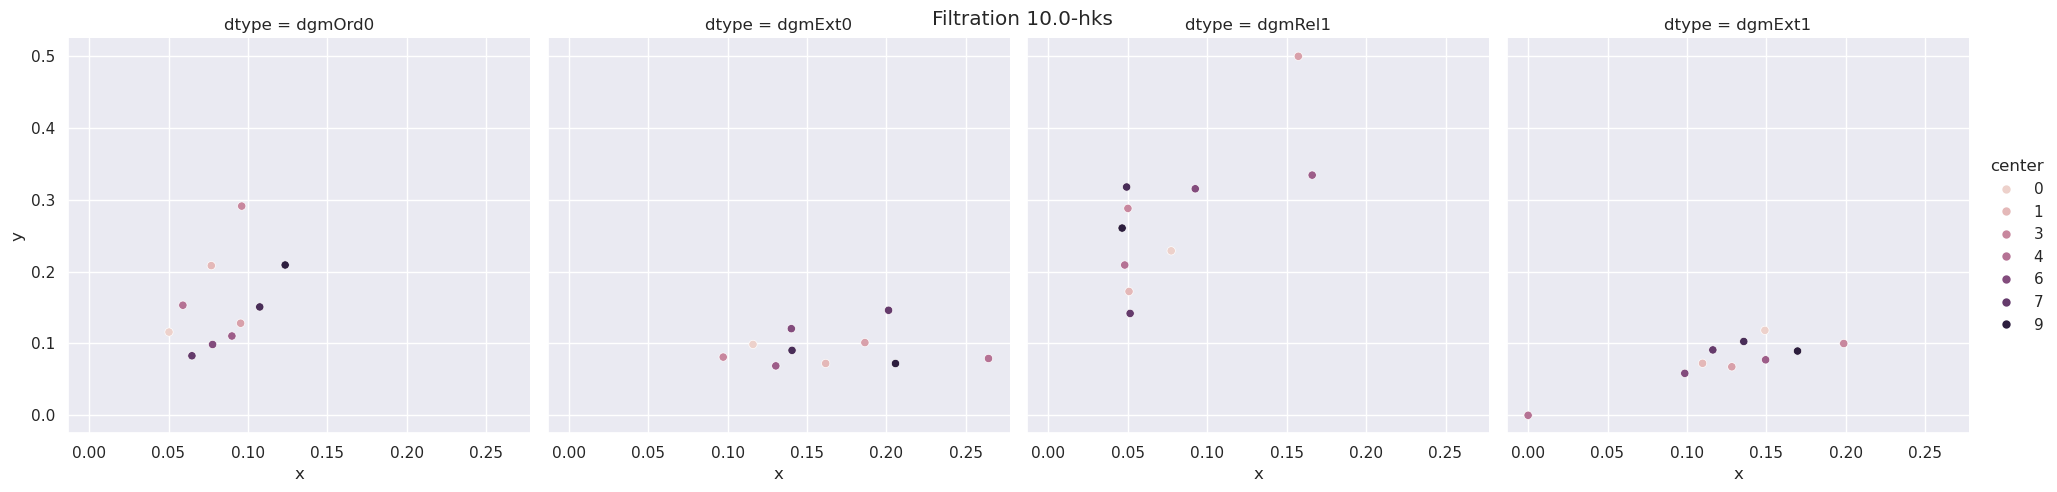

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

num_elements = len(os.listdir(graph_folder + "mat/"))
all_diags = {}  # load all filtrations into memory once for all
for dtype, gid, filt in product(graph_dtypes, np.arange(num_elements), filtrations):
    all_diags[(dtype, filt, gid)] = csv_toarray(graph_folder + "diagrams/%s/graph_%06i_filt_%s.csv" % (dtype, gid, filt))

atol_objs = {(dtype, filt): Atol(quantiser=MiniBatchKMeans(n_clusters=10)) for dtype, filt in product(graph_dtypes, filtrations)}
for dtype, filt in product(graph_dtypes, filtrations) :
    atol_objs[(dtype, filt)].fit([all_diags[(dtype, filt, gid)] for gid in np.arange(num_elements)])

centers_df = []
for dtype, filt in product(graph_dtypes, filtrations):
    clustercenters = atol_objs[(dtype, filt)].centers
    [centers_df.append({"center": _, "x": clustercenters[_, 0], "y": clustercenters[_, 1], "dtype": dtype, "filt": filt}) for _ in range(clustercenters.shape[0])]
centers_df = pd.DataFrame(centers_df)

for filt in filtrations:
    g = sns.relplot(x="x", y="y", hue="center", col="dtype", data=centers_df[centers_df["filt"] == filt])
    g.fig.suptitle("Filtration %s" % filt)

/tmp/ipykernel_18569/3298310186.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data=feats.groupby(["type"]).apply(renormalize))


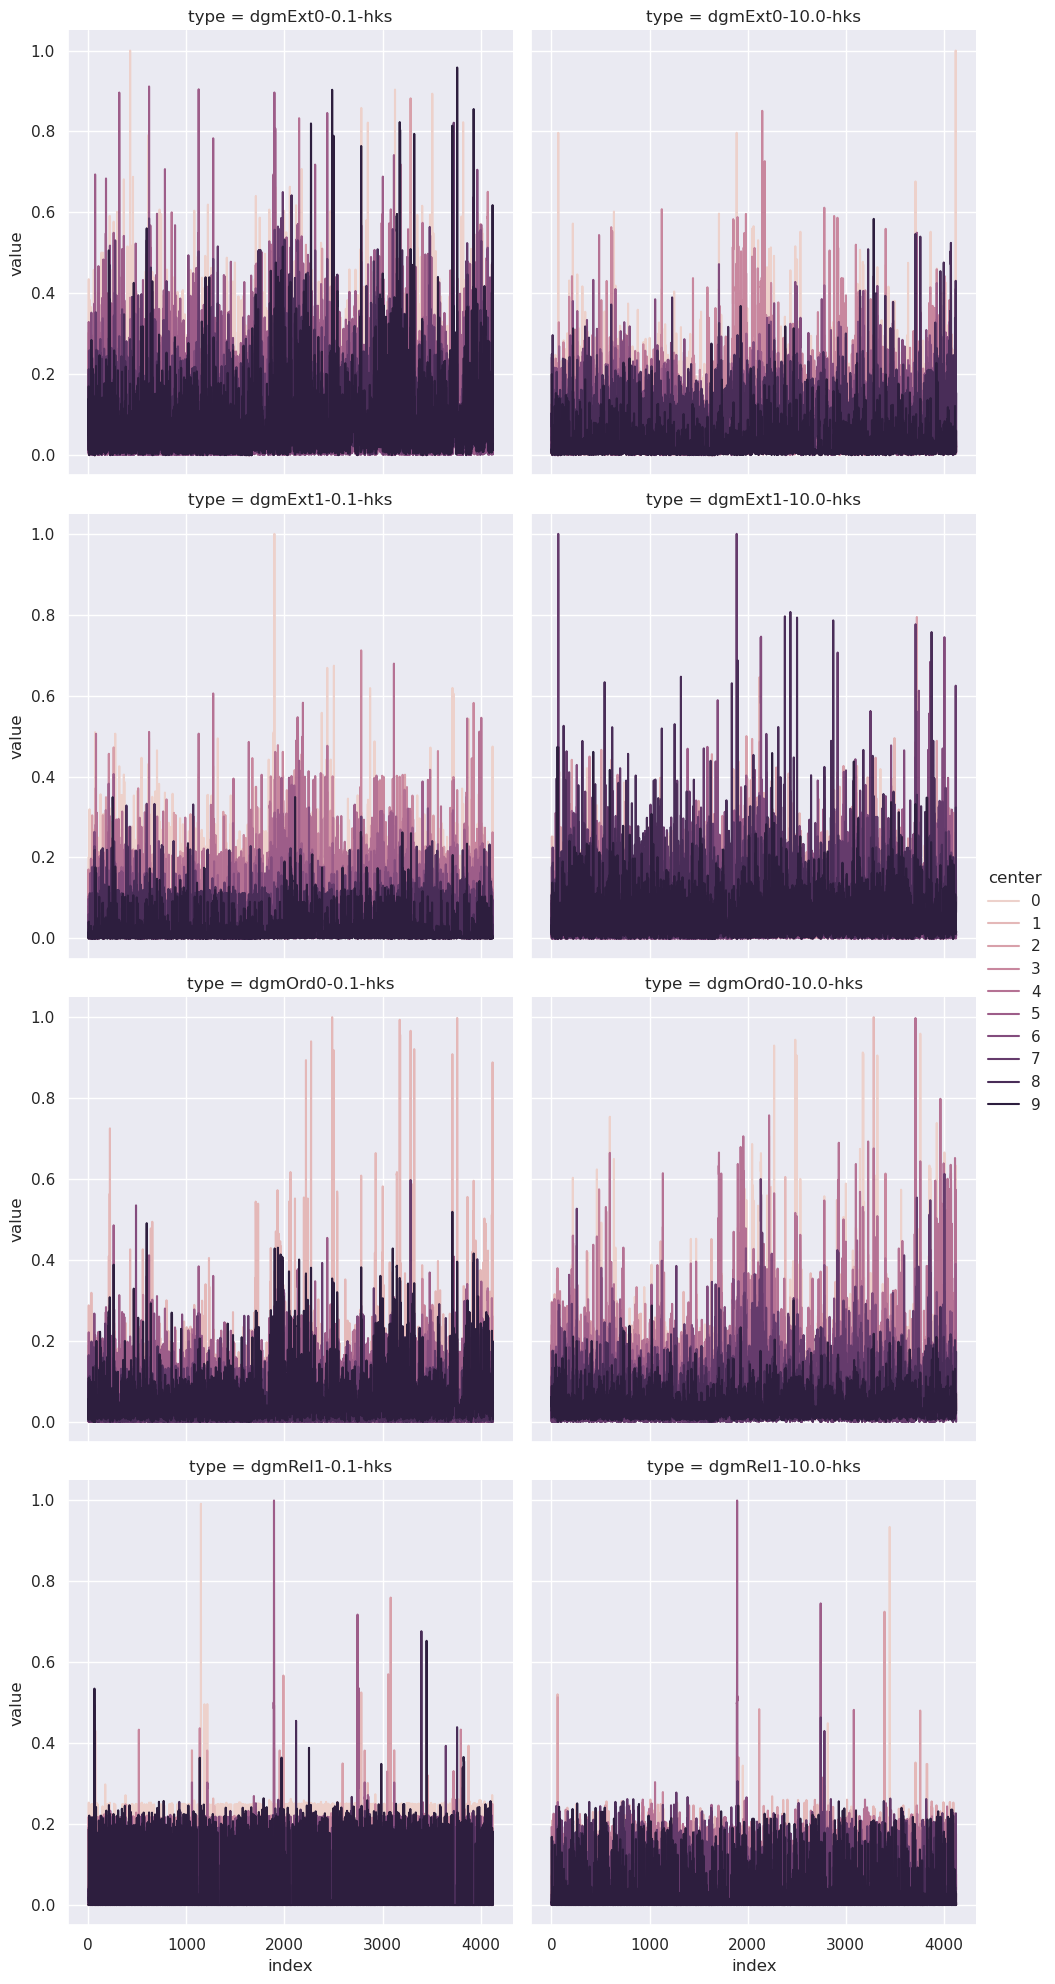

In [41]:
feats = pd.DataFrame(atol_feats_graphs(graph_folder, all_diags, atol_objs),
                     columns=["index", "type", "center", "value", "label"])

import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler
def renormalize(df):
    df["value"] = MinMaxScaler().fit_transform(df["value"].values.reshape(-1, 1))
    return df

sns.relplot(x="index", y="value", kind="line", hue="center", col="type", col_wrap=2, legend="full",
            data=feats.groupby(["type"]).apply(renormalize))

### Ten-fold classification evaluation

In [42]:
from atol.utils import graph_tenfold
print("- [%s] RF classification" % graph_problem)
vfold_scores, feature_times = graph_tenfold(graph_folder, filtrations)
print("- Crossval ended with avg %.4f, sd %.4f" % tuple(f(vfold_scores) for f in [np.mean, np.std]))
print("- Featurisation took %.3f ms" % (np.mean(feature_times) * 1000.0))
print("- [%s] end\n" % graph_problem)

- [NCI109] RF classification
-- Fold 1
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.78
-- Fold 2
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.78
-- Fold 3
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.81
-- Fold 4
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.76
-- Fold 5
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.77
-- Fold 6
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.80
-- Fold 7
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) accuracy_score: 0.78
-- Fold 8
 Descriptors have size: (array([80]), array([3715]))
  (train) accuracy_score: 1.00
  (Test) 